# Homework 9: Mediation & Power Analyses

This homework assignment is designed to give you practice with mediation, and with using Monte Carlo methods to conduct power analyses via simulation. You won't need to load in any data for this homework.

---
## 1. Simulating data (2 points)


In this homework, we're going to simulate the relationship between age, word reading experience, and reading comprehension skill. Older children tend to be better at reading comprehension tasks, but this isn't just an inherent part of getting older. It's a combination of gaining more experience with reading, oral language skills, and executive functions development. In this homework, though, we're going to simplify this relationship down to a direct effect of age on reading comprehension (since improvements in oral language skills and executive functions are more guaranteed as children age than reading practice is), and a mediation of word reading experience.

In graphical form: 
![picture](https://drive.google.com/uc?id=1wdm9xuiJhBJor99-9GnicO2_rzkGWtfN)

Writing the relationship out formally: 

$$x = \beta_{xa} a + \beta_{x0} + \epsilon_{x}$$

$$c = \beta_{ca} a + \beta_{cx} x + \beta_{c0} + \epsilon_c$$



$c$ is reading comprehension, $x$ is word reading experience, and $a$ is age. $\beta_{c0}$ and $\beta_{x0}$ are intercept terms for their respective formulas, and $\epsilon_{c}$ and $\epsilon_{x}$ are gaussian noise terms. We'll start by writing a function, `simulate_data`, that can simulate this relationship. The input values are set and the function structure is provided below. Complete the function such that it takes in those input variables and generates $age$, $x$, and $c$ values. Use `runif()` to generate ages. Use `rnorm()` to generate the noise terms. 

In [1]:
sample_size = 100 # How many children in data set? 
age_lo = 80     # minimum age, in months
age_hi = 200    # maximum age, in months
beta_xa = 0.5   # amount by which experience changes for increase of one month in age
beta_x0 = -5    # amount of experience when age = 0 (not interpretable, since minimum age for this data is 80 months)
sd_x = 50       # standard dev of gaussian noise term, epsilon_x
beta_ca = 0.8   # amount that comprehension score improves for every increase of one unit in age
beta_cx = 3     # amount that comprehension score improves for every increase of one unit in reading experience
beta_c0 = 10    # comprehension score when reading experience is 0. 
sd_c = 85      # standard dev of gaussian noise term, epsilon_c

set.seed(675) 

simulate_data <- function(sample_size, age_lo, age_hi, beta_xa, beta_x0, sd_x, beta_ca, beta_cx, beta_c0, sd_c) {
      age = runif(sample_size, min = age_lo, max = age_hi)
      x_mu = ((beta_xa*age) + beta_x0)
      x = rnorm(sample_size, x_mu, sd_x)
      c_mu = ((beta_ca*age) + (beta_cx*x) + beta_c0)
      c = rnorm(sample_size, c_mu, sd_c)  
      return(data.frame(age=age,x=x,c=c)) # it's actually bad form to have a variable named "c" in R, my bad...
}

dat <- simulate_data(sample_size, age_lo, age_hi, beta_xa, beta_x0, sd_x, beta_ca, beta_cx, beta_c0, sd_c)
head(dat)

,age,x,c
,<dbl>,<dbl>,<dbl>
1,156.91549,127.19026,546.0816
2,140.24697,32.66704,200.0720
3,92.19954,-33.44718,-28.7240
4,174.78368,35.05816,213.2936
5,113.79415,-29.74129,119.5038
6,100.78182,109.86738,411.4757


---
## 2. Visualizing Data (1 point)

Load the `tidyverse` library.

In [4]:
library(tidyverse)

a) Plot the relationship between age and reading comprehension. 

`geom_smooth()` using formula 'y ~ x'



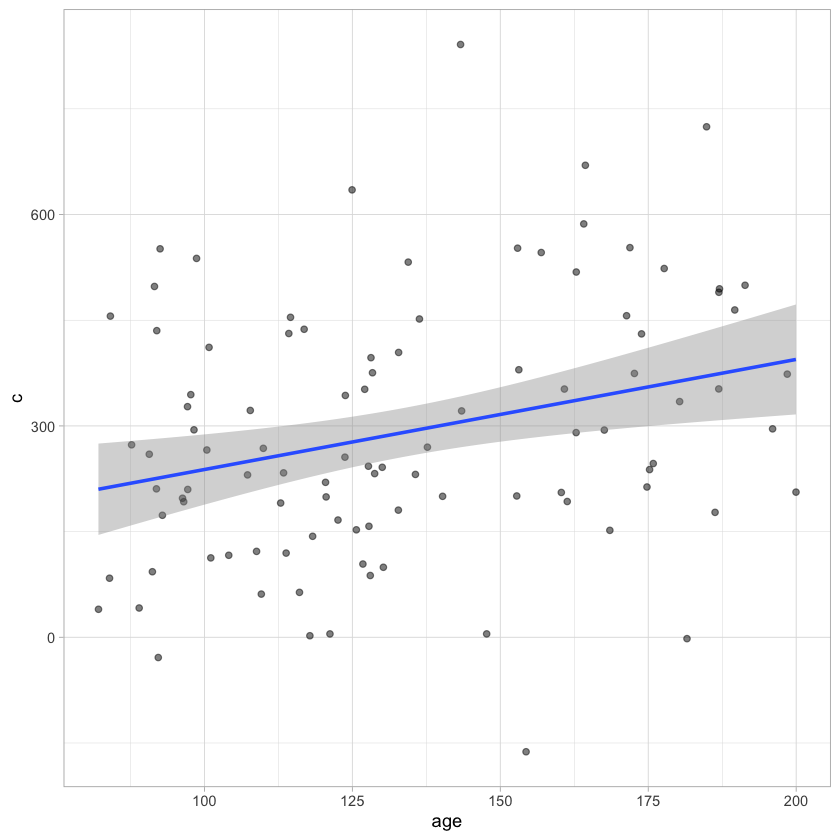

In [3]:
ggplot(dat,aes(x=age,y=c)) + 
geom_point(position="jitter",alpha=0.5) + 
geom_smooth(method = lm) + 
theme_light()

b) Plot the relationship between reading experience, age, and reading comprehension.

`geom_smooth()` using formula 'y ~ x'



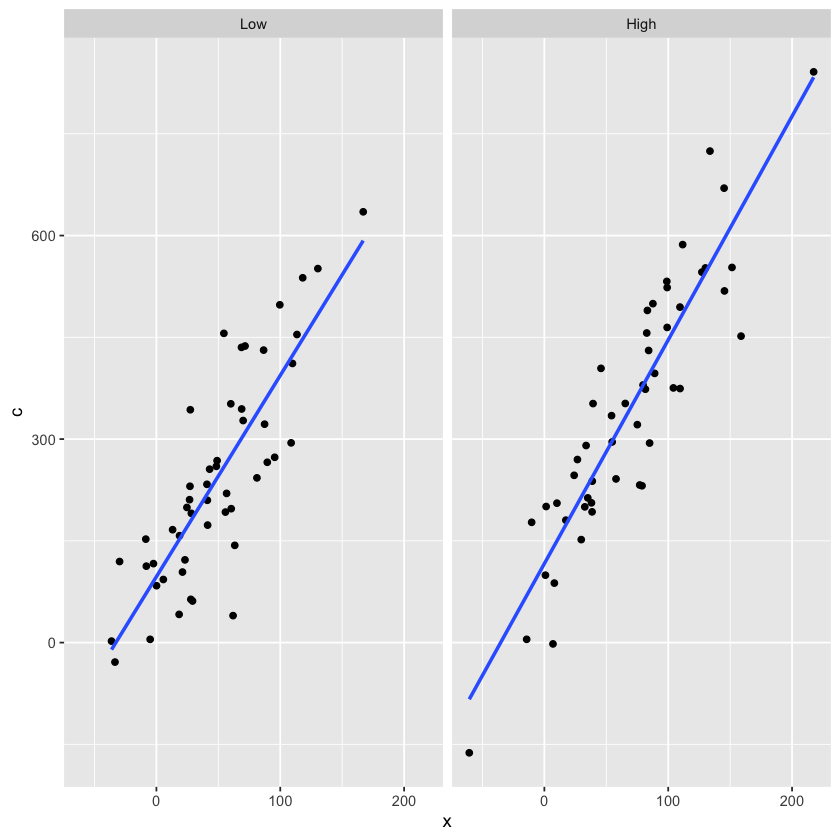

In [5]:
age_median <- median(dat$age)

dat %>%
  mutate(age_split = factor(ifelse(age < age_median,"Low","High"),levels=c("Low","High"))) %>% 
  ggplot(.,aes(x = x,y = c)) + 
  geom_point() + geom_smooth(method="lm",se=FALSE) + # add points and a fit line
  facet_grid(.~age_split)



---
## 3. Mediation Analysis (3 points)

Load the `mediation` library.

In [7]:
library(mediation)

Use the `mediate` function to determine whether `x` mediates the relationship between `age` and `c`. Use `summary()` to print the model results. *Hint: see the mediation and moderation tutorial.*

In [8]:
a.path <- lm(x ~ age, data=dat)
b.path <- lm(c ~ x + age, data=dat)

mediation.model <- mediate(a.path, b.path, treat="age", mediator="x")
summary(mediation.model)


Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

               Estimate 95% CI Lower 95% CI Upper p-value   
ACME              0.791       -0.229         1.70   0.118   
ADE               0.799        0.316         1.31   0.002 **
Total Effect      1.589        0.445         2.71   0.008 **
Prop. Mediated    0.501       -0.335         0.80   0.110   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 100 


Simulations: 1000 


How do you interpret these results? Why do you think the analysis yielded this result? 
> *There is no indirect effect from age on reading comprehension thorugh reading experience. There is, however a direct effect of age on reading comprehension and a total effect of the model.* 

---
## 4. Power Analysis via Simulation (4 points)

Now we're going to use our `simulate_data()` function to conduct a power analysis. The goal is to determine how many participants we would need in order to detect both the mediated and the direct effects in this data. 

*Note: We're going to pretend for the sake of simplicity that we don't have any control over the ages of the children we get (so ages are generated using `runif(sample_size, age_lo, age_hi)`, although of course this would be an unusual situation in reality.*

First, write a function, `run_analysis()`, that takes in simulated data and returns a vector containing the ACME and ADE estimates and p-values (these are the `d0`, `d0.p`, `z0`, and `z0.p` features of the mediated model object, e.g., `fitMed$d0.p`). Print this function's output for the data we simulated previously. 

In [9]:
run_analysis <- function(dat) {
    a.path <- lm(dat$x ~ dat$age)
    b.path <- lm(dat$c ~ dat$x + dat$age)
    fit <- mediate(a.path, b.path, treat="dat$age", mediator="dat$x")
    return(c(ACME = fit$d0, p = fit$d0.p, ADE = fit$z0, p2 = fit$z0.p)) 
}

run_analysis(dat)

ACME         p       ADE        p2 
0.7939343 0.0840000 0.7694283 0.0020000

Next fill in the function `repeat_analysis()` below so that it simulates and analyzes data `num_simulations` times. Store the outputs from each simulation in the `simouts` matrix. Calculate and return the coverage across all the simulations run for both ACME and ADE.

In [11]:
repeat_analysis <- function(num_simulations, alpha, sample_size, age_lo, age_hi, 
        beta_xa, beta_x0, sd_x, beta_ca, beta_cx, beta_c0, sd_c) {
    # Initialize simouts matrix for storing each output from run_analysis()
    simouts <- matrix(rep(NA, num_simulations*4), nrow=num_simulations, ncol=4)
    
    # Start simulating
    for (i in 1:num_simulations) {
      dataset <- simulate_data(sample_size, age_lo, age_hi, beta_xa, beta_x0, sd_x, beta_ca, beta_cx, beta_c0, sd_c)
      simouts[i,] <- run_analysis(dataset)
    }
    
    # Calculate coverage for both ACME and ADE estimates using p-values in simouts
    ACME_cov =  mean(simouts[,2] <= alpha)
    ADE_cov = mean(simouts[,4] <= alpha)

    return(list(ACME_cov = ACME_cov, ADE_cov = ADE_cov))
}


Now run the `repeat_analysis()` function using the same parameter settings as above, for 10 simulations, with an alpha criterion of 0.01. 

In [12]:
set.seed(605)
results = repeat_analysis(num_simulations = 10, alpha = 0.01, sample_size = 100,
                          age_lo = 80, age_hi = 200, beta_xa = 0.5, beta_x0 = -5, sd_x = 50, beta_ca = 0.8, 
                          beta_cx = 3, beta_c0 = 10, sd_c = 85)
results[1:2]


$ACME_cov
[1] 0.8

$ADE_cov
[1] 0.5

Finally, do the same thing (10 simulations, alpha criterion of 0.01) but for 5 different sample sizes: 50, 75, 100, 125, 150. You can do this using `map` (as in the tutorial), or a simple `for` loop, or by calculating each individually. Up to you! This should take around 3 minutes to run. 

In [13]:
# first, create a data.frame to store the results
results.df <- expand.grid(sample_size = c(50,75,100,125,150), alpha = 0.01)
results.df$id <- 1:nrow(results.df) #identify each combination of parameters as a separate parameter case for below (otherwise, "unnesting" will be impossible)

# then use tidyverse functions to run the analysis for each sample size
results <- results.df  %>%  #using the dataframe defined above
    nest(parameters :=  c(sample_size, alpha)) %>% # separate the parameters into lists split by parameter combo case and call the new column of lists 'parameters' 
    mutate(ACMEcov = map(parameters, ~ repeat_analysis(10, .$alpha, .$sample_size, age_lo, age_hi, beta_xa, beta_x0, sd_x, beta_ca, 
                          beta_cx, beta_c0, sd_c)$ACME_cov))  %>% 
    mutate(ADEcov = map(parameters, ~ repeat_analysis(10, .$alpha, .$sample_size, age_lo, age_hi, beta_xa, beta_x0, sd_x, beta_ca, 
                          beta_cx, beta_c0, sd_c)$ACME_cov))  %>% 
    unnest(c(parameters, ACMEcov, ADEcov)) #return the dataframe to an unnested state, making each element of the list its own row


Print your results. 

In [14]:
head(results)


id,sample_size,alpha,ACMEcov,ADEcov
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,50,0.01,0.4,0.4
2,75,0.01,0.8,0.7
3,100,0.01,0.8,1.0
4,125,0.01,0.8,1.0
5,150,0.01,1.0,1.0


If this were a real power analysis, we'd want to run more simulations per sample size (to get a more precise estimate of power) and we may also want to test out some other values of the parameters we used to simulate our data. However, what would you conclude just based on the results above? 

> *The results of this power analysis suggest that, at a sample size of 100, we have a 80% probability that we correctly reject the null of the indirect effect (no indirect effect) aand a 100% probability that we correctly reject the null of the direct effect. The power increases for both effects as the sample size increases. To have 100% probability of correctly rejecting the null for both the direct and indirect effects, we would need a sample size of 150.*
> 

**Given** how we generated the data, why was the direct effect harder to detect than the mediated effect?
> *The fact that the direct effect was harder to detect than the mediated effect may have something to do with the way that the age and reading experience variables were generated. Age was stimulated by random generation using just a minimum and maximum age value. Word reading experience was then calculated by multiplying age by the amount by which experience changes for a mone month increase in age and adding this to the word reading experience at age 0 months (intercept). This latter intercept value is uninterpretable because the minimum age value in the sampe is 80 months. This may have led to random mapping between age and word reading experience, which may influence our ability to detect effects between age and the mediator (word reading experience)* 
> 

**DUE:** 5pm EST, April 11, 2022

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Delainey Wescott & Isabella Kahhale*